<a href="https://colab.research.google.com/github/namoshi/colab/blob/master/Using_torch_and_%F0%9F%A4%97_transformers_with_sklearn_functionalities_using_skorch_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning a BERT model with skorch and huggingface

In this notebook, we follow the fine-tuning guideline from [Hugging Face documentation](https://huggingface.co/docs/transformers/training). Please check it out if we you want to know more about BERT and fine-tuning. Here, we assume that you're familiar with the general ideas.

You will learn how to:
- integrate the [Hugging Face transformers](https://huggingface.co/docs/transformers/index) library with skorch
- use skorch to fine-tune a BERT model on a text classification task
- use skops to serialize & push our model to Hugging Face Hub

<table align="left"><td>
<a target="_blank" href="https://colab.research.google.com/github/skorch-dev/skorch/blob/master/notebooks/Huggingface_Finetuning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank" href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Huggingface_Finetuning.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

The first part of the notebook requires hugginface `transformers` as an additional dependency. If you have not already installed it, you can do so like this:

`python -m pip install transformers`

In [1]:
!pip install git+https://github.com/skorch-dev/skorch.git
!pip install skops 
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/skorch-dev/skorch.git to /tmp/pip-req-build-cq6todn5
  Running command git clone -q https://github.com/skorch-dev/skorch.git /tmp/pip-req-build-cq6todn5
  Created wheel for skorch: filename=skorch-0.11.1.dev0-py3-none-any.whl size=227765 sha256=b9cf49c41c66ac4dfdecefe1cc116e11495c0d041248276fac3c90dfdf832802
  Stored in directory: /tmp/pip-ephem-wheel-cache-t92sae79/wheels/ba/d8/54/8b2dfa7a44117ebfcb5ab97bc702fcf288036748556d545396
Successfully built skorch
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 163 kB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.6 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 
Looking in indexes: https://pypi.org/sim

## Imports

In [2]:
import numpy as np
import torch
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, 
                            ConfusionMatrixDisplay, classification_report)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from skops import card, hub_utils
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, ProgressBar
from skorch.hf import HuggingfacePretrainedTokenizer
from torch import nn
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
# for model hosting and requirements
from pathlib import Path 
import transformers
import skorch
import sklearn 
import torch

## Parameters

Change the values below if you want to try out different model architectures and hyper-parameters.

In [3]:
# Choose a tokenizer and BERT model that work together
TOKENIZER = "distilbert-base-uncased"
PRETRAINED_MODEL = "distilbert-base-uncased"

# model hyper-parameters
OPTMIZER = torch.optim.AdamW
LR = 5e-5
MAX_EPOCHS = 3
CRITERION = nn.CrossEntropyLoss
BATCH_SIZE = 8

# device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

In [4]:
dataset = fetch_20newsgroups()

For this notebook, we're making use the 20 newsgroups dataset. It is a text classification dataset with 20 classes. A decent score would be to reach 89% accuracy out of sample. For more details, read the description below:

In [5]:
print(dataset.DESCR.split('Usage')[0])

.. _20newsgroups_dataset:

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality

In [6]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [7]:
X = dataset.data
y = dataset.target

In [8]:
X_train, X_test, y_train, y_test, = train_test_split(X, y, stratify=y, random_state=0)

In [9]:
X_train[:2]

['From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject: Re: ARMENIA SAYS IT COULD SHOOT DOWN TURKISH PLANES (Henrik)\nLines: 53\nNntp-Posting-Host: alban.dsv.su.se\nReply-To: hilmi-er@dsv.su.se (Hilmi Eren)\nOrganization: Dept. of Computer and Systems Sciences, Stockholm University\n\n\n  \n|>      henrik@quayle.kpc.com writes:\n\n\n|>\tThe Armenians in Nagarno-Karabagh are simply DEFENDING their RIGHTS\n|>        to keep their homeland and it is the AZERIS that are INVADING their \n|>        territorium...\n\t\n\n\tHomeland? First Nagarno-Karabagh was Armenians homeland today\n\tFizuli, Lacin and several villages (in Azerbadjan)\n\tare their homeland. Can\'t you see the\n\tthe  "Great Armenia" dream in this? With facist methods like\n\tkilling, raping and bombing villages. The last move was the \n\tblast of a truck with 60 kurdish refugees, trying to\n\tescape the from Lacin, a city that was "given" to the Kurds\n\tby the Armenians. \n\n\n|>       However, I hope that the Armenians WILL for

## Prepare the training

We want to use a linear learning rate schedule that linearly decreases the learning rate during training.

In [10]:
num_training_steps = MAX_EPOCHS * (len(X_train) // BATCH_SIZE + 1)

def lr_schedule(current_step):
    factor = float(num_training_steps - current_step) / float(max(1, num_training_steps))
    assert factor > 0
    return factor

Next we wrap the BERT module itself inside a simple `nn.Module`. The only real work for us here is to load the pretrained model and to return the _logits_ from the model output. The rest of the outputs is not needed.

In [11]:
class BertModule(nn.Module):
    def __init__(self, name, num_labels):
        super().__init__()
        self.name = name
        self.num_labels = num_labels
        
        self.reset_weights()
        
    def reset_weights(self):
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            self.name, num_labels=self.num_labels
        )
        
    def forward(self, **kwargs):
        pred = self.bert(**kwargs)
        return pred.logits

### Tokenizer

We make use of `HuggingfacePretrainedTokenizer`, which is a wrapper that skorch provides to use the tokenizers from Hugging Face. In this instance, we use a tokenizer that was pretrained in conjunction with BERT. The tokenizer is automatically downloaded if not already present. More on Hugging Face tokenizers can be found [here](https://huggingface.co/docs/tokenizers/index).

## Training

### Putting it all togther

Now we can put together all the parts from above. There is nothing special going on here, we simply use an sklearn `Pipeline` to chain the `HuggingfacePretrainedTokenizer` and the neural net. Using skorch's `NeuralNetClassifier`, we make sure to pass the `BertModule` as the first argument and to set the number of labels based on `y_train`. The criterion is `CrossEntropyLoss` because we return the logits. Moreover, we make use of the learning rate schedule we defined above, and we add the `ProgressBar` callback to monitor our progress.

In [12]:
pipeline = Pipeline([
    ('tokenizer', HuggingfacePretrainedTokenizer(TOKENIZER)),
    ('net', NeuralNetClassifier(
        BertModule,
        module__name=PRETRAINED_MODEL,
        module__num_labels=len(set(y_train)),
        optimizer=OPTMIZER,
        lr=LR,
        max_epochs=MAX_EPOCHS,
        criterion=CRITERION,
        batch_size=BATCH_SIZE,
        iterator_train__shuffle=True,
        device=DEVICE,
        callbacks=[
            LRScheduler(LambdaLR, lr_lambda=lr_schedule, step_every='batch'),
            ProgressBar(),
        ],
    )),
])

Since we are using skorch, we could now take this pipeline to run a grid search or other kind of hyper-parameter sweep to figure out the best hyper-parameters for this model. E.g. we could try out a different BERT model or a different `max_length`.

### Fitting

In [13]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

In [14]:
%time pipeline.fit(X_train, y_train)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.1594       0.8403        0.5534  176.9885


      2        0.3690       0.8904        0.3961  177.5839


      3        0.1513       0.8969        0.3756  177.4642


CPU times: user 7min 21s, sys: 1min 49s, total: 9min 11s
Wall time: 9min 11s


Pipeline(steps=[('tokenizer',
                 HuggingfacePretrainedTokenizer(tokenizer='distilbert-base-uncased')),
                ('net',
                 <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BertModule(
    (bert): DistilBertForSequenceClassification(
      (distilbert): DistilBertModel(
        (embeddings): Embeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddin...
                (lin1): Linear(in_features=768, out_features=3072, bias=True)
                (lin2): Linear(in_features=3072, out_features=768, bias=True)
                (activation): GELUActivation()
              )
              (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            )
          )
        )
      )
      (pre_classifier): Linear(in_features=768, out_features=768, bias=True)
      (classifier): Linear(in_features=768, out_features=20, bias=True)
      (dropout): Dropout(p=0.2, inplace

### Evaluation

In [15]:
%%time
with torch.inference_mode():
    y_pred = pipeline.predict(X_test)

CPU times: user 25.5 s, sys: 63.4 ms, total: 25.6 s
Wall time: 23.4 s


In [16]:
accuracy_score(y_test, y_pred)

0.9056203605514316

We can be happy with the results. We set ourselves the goal to reach or exceed 89% accuracy on the test set and we managed to do that.
We will save our model, create a model card and push it to Hugging Face Hub now. This will give us a repository containing the model, an automatically created widget of the model and a model card.

In [ ]:
# Save the model
import pickle
with open("model.pkl", mode="bw") as f:
    pickle.dump(pipeline, file=f)

We will initialize a local repository with our model. We will put plots, model cards and more in this repository and will push this repository later.
We need to pass requirements to the config file of the model, we can do this during initialization. 

In [ ]:
local_repo = "model_repo"
hub_utils.init(
    model="model.pkl",
    requirements=[f"scikit-learn={sklearn.__version__}", f"transformers={transformers.__version__}",
                  f"torch={torch.__version__}", f"skorch={skorch.__version__}"],
    dst=local_repo,
    task="text-classification",
    data=X_test,
)

We will now initialize the model card. `metadata_from_config` takes metadata information of model card from config file. 
We will add a description about the model and limitations of the model in the model card.



In [ ]:
model_card = card.Card(pipeline, metadata=card.metadata_from_config(Path("model_repo")))


In [ ]:
model_description = (
    "This is a neural net classifier and distilbert model chained with sklearn Pipeline trained on 20 news groups dataset."
)
limitations = "This model is trained for a tutorial and is not ready to be used in production."
model_card.add(
    model_description=model_description,
    limitations=limitations
)

Card(
  model=Pipeline(steps=[('tokenizer',...pout(p=0.2, inplace=False) ) ), ))]),
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'text-classification'],
  model_description='This is a neural... trained on 20 news groups dataset.',
)

We will evaluate model and add the evaluation results to the model card.

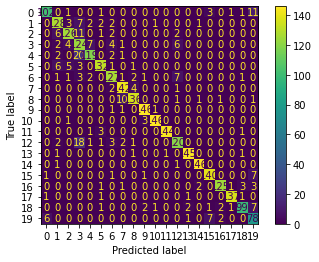

In [ ]:
eval_descr = (
    "The model is evaluated on validation data from 20 news group's test split,"
    " using accuracy and F1-score with micro average."
)
model_card.add(eval_method=eval_descr)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="micro")
model_card.add_metrics(**{"accuracy": accuracy, "f1 score": f1})

cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot()

disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
model_card.add_plot(**{"Confusion matrix": "confusion_matrix.png"})

clf_report = classification_report(
    y_test, y_pred, output_dict=True, target_names=dataset.target_names
)
# We first need to convert classification report to DataFrame to add it as a table
import pandas as pd
del clf_report["accuracy"]
clf_report = pd.DataFrame(clf_report).T.reset_index()
model_card.add_table(
    folded=True,
    **{
        "Classification Report": clf_report,
    },
)

# We will save our model now

model_card.save(Path(local_repo) / "README.md")

We need to login to Hugging Face Hub using `notebook_login()` to authenticate our account. We will then push our model to a repository on Hub called "skorch-text-classification". `create_remote` creates the repository on Hub if it doesn't exist. 

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
hub_utils.push(
    repo_id="scikit-learn/skorch-text-classification",
    source=local_repo,
    create_remote=True,
)